In [1]:
# Plot zones where these things are true vs. radius (just stripes on an x-axis or something):
# t_conv < 1e8 & L_conv < 1e42
# t_conv < 1e8 & L_conv > 1e42
# t_conv > 1e8

In [2]:
# import as needed
import mesa_reader as mr
import matplotlib.pylab as plt
import numpy as np
import os
from math import log
from scipy.integrate import cumtrapz
import math

G = 6.67408e-11 # gravitational constant
# change G to cgs units
G = G * 1e3

In [3]:
# find and import the profile closest to your target profile

def getClosestModel(modelNumber, workingDirectory):
    print('Looking for the profile closest to model #' + str(modelNumber) + ' in ' + str(workingDirectory))
    filenames = []

    for root, dirs, files in os.walk(workingDirectory):
        for file in files:
            if file.endswith("profiles.index"):
                filenames.append(os.path.join(root, file))

    profiles = []
    # import files
    for file in filenames:
        i = mr.MesaProfileIndex(file)
        profiles.append(i)

    # find the closest model number - ugly but functional
    closest = 0
    diff = 1e10
    profilePath = ''
    j = 0
    for index in profiles:
        values = index.model_numbers
        profileNums = index.profile_numbers
        k=0
        for i in values:
            if (abs(modelNumber - i) < diff):
                diff = abs(modelNumber - i)
                closest = i
                og = filenames[j]
                og = og[:-14] # put together the file name given the directory
                profilePath = og + 'profile' + str(profileNums[k]) + '.data'
            k+=1
        j+=1

    print('Actual model number: ' + str(closest))
    print('Difference between target and actual model: ' + str(diff))
    print('File path: ' + str(profilePath))
    print('')

    # import target profile
    p = mr.MesaData(profilePath)
    return p

directory = '/Users/emilyflynn/Desktop/25M_tests/15M_logs/'
p15 = getClosestModel(2050, directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/20M_logs/'
p20 = getClosestModel(2377, directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/25M_logs/'
p25 = getClosestModel(394, directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/30M_logs/'
p30 = getClosestModel(294, directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/50M_logs/'
p50 = getClosestModel(189, directory)

directory = '/Users/emilyflynn/Desktop/25M_tests/70M_logs/'
p70 = getClosestModel(905, directory)

Looking for the profile closest to model #2050 in /Users/emilyflynn/Desktop/25M_tests/15M_logs/
Actual model number: 2050
Difference between target and actual model: 0
File path: /Users/emilyflynn/Desktop/25M_tests/15M_logs/profile48.data

Looking for the profile closest to model #2377 in /Users/emilyflynn/Desktop/25M_tests/20M_logs/
Actual model number: 2400
Difference between target and actual model: 23
File path: /Users/emilyflynn/Desktop/25M_tests/20M_logs/profile55.data

Looking for the profile closest to model #394 in /Users/emilyflynn/Desktop/25M_tests/25M_logs/
Actual model number: 400
Difference between target and actual model: 6
File path: /Users/emilyflynn/Desktop/25M_tests/25M_logs/LOGS_to_si_burn/profile2.data

Looking for the profile closest to model #294 in /Users/emilyflynn/Desktop/25M_tests/30M_logs/
Actual model number: 300
Difference between target and actual model: 6
File path: /Users/emilyflynn/Desktop/25M_tests/30M_logs/LOGS_before_remove/profile13.data

Looking f

In [4]:
# go ahead and import radius for everything
def getRadius(p, localSim):
    
    if localSim:
            r = p.logR       # bring in the radius
            r = 10**r        # un-log it

    else:
        r = p.radius     # bring in the radius

    r = r*69.551e9   # change units to cm
    r = r[100:]      # cut off the first 100 points - takes care of surface weirdness
    
    return r

r15 = getRadius(p15, False)
r20 = getRadius(p20, False)
r25 = getRadius(p25, True)
r30 = getRadius(p30, True)
r50 = getRadius(p50, True)
r70 = getRadius(p70, True)

In [5]:
# get tconv

# if they are from the MESA site it should be (p, False, True)
# if we made them it is (p, True, False)

def getConvZones(p, rLogForm, nearZero):
    
    if rLogForm:
        r = p.logR       # bring in the radius
        r = 10**r        # un-log it

    else:
        r = p.radius     # bring in the radius
    
    r = r*69.551e9   # change units to cm
    r = r[100:]      # cut off the first 100 points - takes care of surface weirdness

    v = p.log_conv_vel
    
    if nearZero:
        v = [i if i>1e-8 else 1e-8 for i in v] # if having issues with v being too close to 0
    
    v = np.power(10, v) # un-log it
    v = -1/v            # it'll be integrated like this
    v = v[100:]         # cut off first 100 points

    # integrate
    tconv = []
    tconv = cumtrapz(y=v, x=r)

    return tconv

tconv15 = getConvZones(p15, False, True)
tconv20 = getConvZones(p20, False, True)
tconv25 = getConvZones(p25, True, True)
tconv30 = getConvZones(p30, True, False)
tconv50 = getConvZones(p50, True, False)
tconv70 = getConvZones(p70, True, False)

/Users/emilyflynn/anaconda3/lib/python3.7/site-packages/mesa_reader/__init__.py:335: RuntimeWarning: divide by zero encountered in log10
  return np.log10(self.bulk_data[self._exp10_version(key)])


In [6]:
# get lum
# max luminosity

def getMaxLum(p, localSim):
    if localSim:
        r = p.logR       # bring in the radius
        r = 10**r        # un-log it

    else:
        r = p.radius     # bring in the radius

    r = r*69.551e9   # change units to cm
    r = r[100:]      # cut off the first 100 points - takes care of surface weirdness

    # need: beta ~ 5, 4pi, density[r], radius, sound speed c[r]
    # define a constant, k
    k = 5 * 4 * math.pi

    # get density
    rho = p.logRho
    rho = 10**rho
    
    # get sound speed
    if localSim:
        c = p.csound
    
    else:
        # the web files don't have csound
        # csound=sqrt(5/3*pressure[r] / rho[r])
        ks = 5 * p.pressure / 3
        c = np.sqrt(ks / rho)
        
    c = c[100:]
    rho = rho[100:]

    lumMax = k * r**2 * rho * c**3
    return lumMax

lumMax15 = getMaxLum(p15, False)
lumMax20 = getMaxLum(p20, False)
lumMax25 = getMaxLum(p25, True)
lumMax30 = getMaxLum(p30, True)
lumMax50 = getMaxLum(p50, True)
lumMax70 = getMaxLum(p70, True)

In [7]:
# determine which situation it is
tconvBound = 1e8
lconvBound = 1e45

def findZone(tconv, lconv):
    if ((tconv < tconvBound) and (lconv < lconvBound)):
        return 'removeAll'
    
    elif ((tconv < tconvBound) and (lconv > lconvBound)):
        return 'removeLimited'
    
    elif (tconv > tconvBound):
        return 'removeNone'
    
    return 'none'

# just get the maximum radius
def getMaxRadius(rList):
    return rList[0]

# normalize the radius by dividing by the max radius
def normalizeRadius(r, maxR):
    normR = r / maxR
    return normR

No handles with labels found to put in legend.


(10, 90)

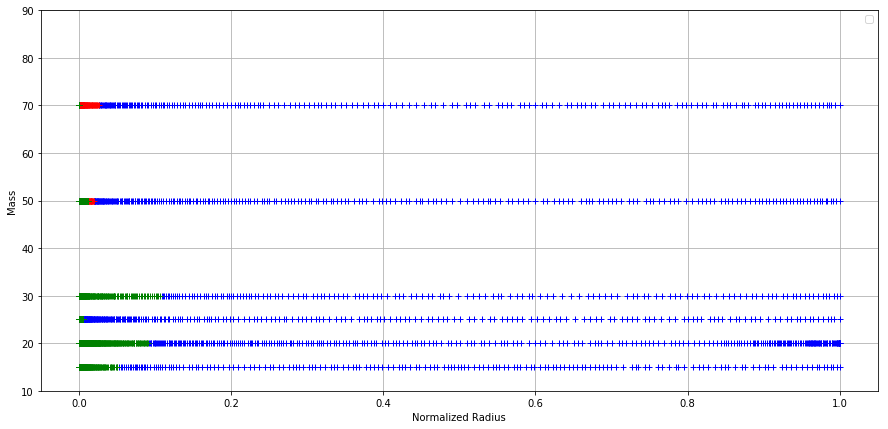

In [11]:
# actually plot n stuff
fig, ax = plt.subplots(figsize=(15,7))
plt.xlabel('Normalized Radius')
plt.ylabel('Mass')
plt.grid(True)

def plotConvZones(r, lumMax, tconv, mass):
    
    # tconv is always awkwardly short
    r = r[:-1]
    lumMax = lumMax[:-1]

    l = len(r)
    maxR = getMaxRadius(r)
    n = normalizeRadius(r, maxR)

    for i in range(l):
        s = findZone(tconv[i], lumMax[i])

        color = ''
        name = ''

        if (s == 'removeAll'):
            color = 'b+'
            name = 'remove all'

        elif (s == 'removeLimited'):
            color = 'r+'
            name = 'remove some'

        elif (s == 'removeNone'):
            color = 'g+'
            name = 'dsdseesf'
            
        plt.plot(n[i], mass, color, label=name)
        
# bit of a hacky way to make a legend
# p1, = plt.plot(0, 0, 'bo')
# p2, = plt.plot(0, 0, 'ro')
# p3, = plt.plot(0, 0, 'go')

plt.legend()
        
plotConvZones(r15, lumMax15, tconv15, 15)
plotConvZones(r20, lumMax20, tconv20, 20)
plotConvZones(r25, lumMax25, tconv25, 25)
plotConvZones(r30, lumMax30, tconv30, 30)
plotConvZones(r50, lumMax50, tconv50, 50)
plotConvZones(r70, lumMax70, tconv70, 70)

# plt.legend((p1, p2, p3), ('remove all', 'remove limited', 'remove none'))
plt.ylim(10, 90)